### Домашняя работа к уроку 6

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

Используем встроенный датасет про диабет:

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
def gb_predict(X, trees_list, eta):
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

Функционал ошибки - С.К.О.:

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Функция для расчета остатка:

In [7]:
def residual(y, z):
    return - (z - y)

Функция обучения градиентного бустинга:

In [9]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

#### Задача 1
Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров.

In [35]:
from tqdm import tqdm

eta = 1
max_depths = range(1, 21)


def scan_max_depths(n_trees=n_trees, max_depths=max_depths):
    train_errors_depths = []
    test_errors_depths = []

    for max_depth in tqdm(max_depths):
        _, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
        train_errors_depths.append(train_errors[-1])
        test_errors_depths.append(test_errors[-1])
        
    return train_errors_depths, test_errors_depths


In [41]:
train_errors_3_trees, test_errors_3_trees = scan_max_depths(n_trees=3)
train_errors_5_trees, test_errors_5_trees = scan_max_depths(n_trees=5)
train_errors_10_trees, test_errors_10_trees = scan_max_depths(n_trees=10)
train_errors_20_trees, test_errors_20_trees = scan_max_depths(n_trees=20)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:13<00:00,  6.66s/it]


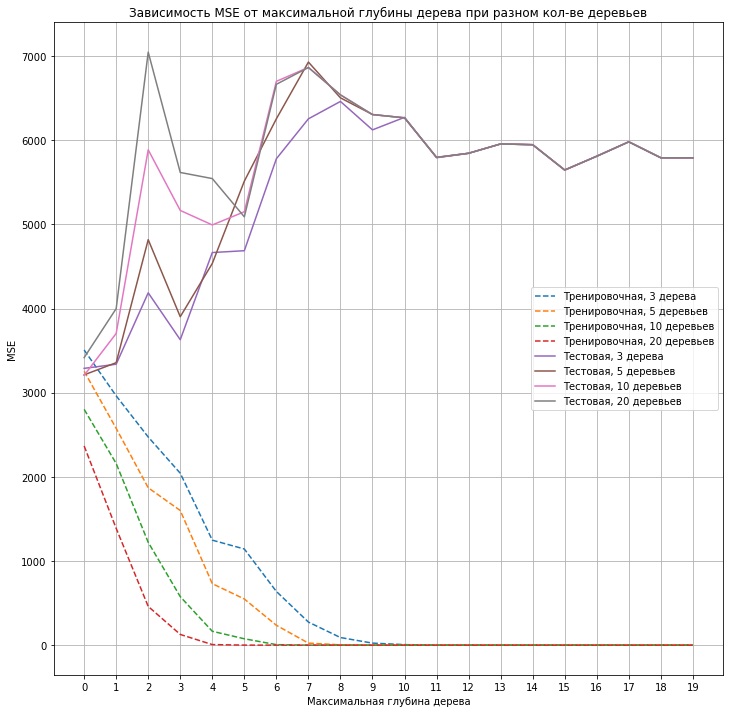

In [59]:
plt.figure(figsize=(12, 12))
plt.plot(range(len(max_depths)), train_errors_3_trees, label='Тренировочная, 3 дерева', linestyle='--')
plt.plot(range(len(max_depths)), train_errors_5_trees, label='Тренировочная, 5 деревьев', linestyle='--')
plt.plot(range(len(max_depths)), train_errors_10_trees, label='Тренировочная, 10 деревьев', linestyle='--')
plt.plot(range(len(max_depths)), train_errors_20_trees, label='Тренировочная, 20 деревьев', linestyle='--')
plt.plot(range(len(max_depths)), test_errors_3_trees, label='Тестовая, 3 дерева')
plt.plot(range(len(max_depths)), test_errors_5_trees, label='Тестовая, 5 деревьев')
plt.plot(range(len(max_depths)), test_errors_10_trees, label='Тестовая, 10 деревьев')
plt.plot(range(len(max_depths)), test_errors_20_trees, label='Тестовая, 20 деревьев')
plt.xlabel('Максимальная глубина дерева')
plt.xticks(np.arange(0, 20, 1))
plt.ylabel('MSE')
plt.title('Зависимость MSE от максимальной глубины дерева при разном кол-ве деревьев')
plt.legend(loc='best')
plt.grid()
plt.show()

$Вывод:$ При увеличении максимальной глубины дерева ошибка на тренировочной выборке падает (к глубине=10 практически в ноль), а на тестовой выборке после глубины=3 возрастает, что говорит о переобучении. В данном случае, для тестовой выборки оптимальным будет 3 дерева с максимальной глубиной=3.